# Imports

In [141]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [252]:
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.metrics import mean_squared_error

import xgboost as xgb
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

# Data Load

In [247]:
df = pd.read_pickle('/Users/lj/code/5pacepenguin/nba_betting_analysis/nba_betting_analysis/backend/data/pkl/scaled_boxscore_advanced_rolling_players.pkl')
df

,PLAYER_ID,GAME_DATE,PLAYER_NAME,PLUS_MINUS,AST_PCT,AST_RATIO,AST_TOV,DEF_RATING,DREB_PCT,EFG_PCT,MIN,NET_RATING,OFF_RATING,OREB_PCT,PACE,PIE,POSS,PTS,REB_PCT,TM_TOV_PCT,TS_PCT,USG_PCT
0,1713,2018-12-03,Vince Carter,-14.9,0.123266,0.169653,0.042814,0.578202,0.250375,0.402074,0.329102,0.501794,0.587002,0.050330,0.014105,0.542849,0.347285,0.421875,0.228959,0.072430,0.431366,0.376921
1,1713,2018-12-05,Vince Carter,-14.8,0.132462,0.147789,0.042814,0.546110,0.255056,0.432649,0.366260,0.513995,0.573205,0.064214,0.013059,0.548627,0.383484,0.437500,0.231373,0.072430,0.465736,0.384718
2,1713,2018-12-08,Vince Carter,-13.9,0.147144,0.161434,0.057086,0.548544,0.268539,0.466538,0.354895,0.515012,0.577199,0.083652,0.013363,0.554863,0.373303,0.437500,0.249472,0.090059,0.499260,0.418802
3,1713,2018-12-12,Vince Carter,-13.9,0.125686,0.163571,0.014271,0.554043,0.256742,0.414582,0.347681,0.500778,0.561224,0.065255,0.014036,0.548169,0.368778,0.445312,0.231071,0.070731,0.447864,0.404767
4,1713,2018-12-14,Vince Carter,-11.5,0.125686,0.163571,0.014271,0.595691,0.256742,0.396729,0.346915,0.476435,0.566125,0.047900,0.013775,0.547654,0.367647,0.474609,0.221418,0.070731,0.422377,0.418133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100079,1631323,2023-02-23,Simone Fontecchio,0.6,0.092611,0.167352,0.071357,0.566844,0.141199,0.415758,0.251965,0.588337,0.706635,0.133287,0.012827,0.522883,0.263575,0.759766,0.171342,0.267842,0.421003,0.387391
100080,1631323,2023-02-25,Simone Fontecchio,2.3,0.107293,0.190860,0.071357,0.579735,0.141199,0.429121,0.264539,0.622010,0.770627,0.152725,0.012945,0.538387,0.277149,0.761719,0.182202,0.214741,0.455690,0.367788
100081,1631323,2023-02-28,Simone Fontecchio,-0.8,0.128751,0.218313,0.080919,0.630758,0.094382,0.375668,0.305364,0.582356,0.761732,0.152725,0.012803,0.522654,0.319005,0.699219,0.139065,0.267842,0.402813,0.317665
100082,1631323,2023-03-03,Simone Fontecchio,-5.3,0.139561,0.228670,0.095191,0.612729,0.045880,0.277635,0.358884,0.601974,0.773260,0.096147,0.011583,0.523112,0.369910,0.666016,0.080543,0.139550,0.305626,0.312542


In [145]:
df.dtypes

PLAYER_ID            category
GAME_DATE      datetime64[ns]
PLAYER_NAME          category
PLUS_MINUS            float64
AST_PCT               float64
AST_RATIO             float64
AST_TOV               float64
DEF_RATING            float64
DREB_PCT              float64
EFG_PCT               float64
MIN                   float64
NET_RATING            float64
OFF_RATING            float64
OREB_PCT              float64
PACE                  float64
PIE                   float64
POSS                  float64
PTS                   float64
REB_PCT               float64
TM_TOV_PCT            float64
TS_PCT                float64
USG_PCT               float64
dtype: object

# Model

## Train-test split

In [169]:
# taken from neural_net.ipynb
train_test_split_date = '2022-04-27 00:00:00'
X_train = df.loc[df.GAME_DATE < train_test_split_date, ~df.columns.isin(['PLUS_MINUS'])]
X_test = df.loc[df.GAME_DATE > train_test_split_date, ~df.columns.isin(['PLUS_MINUS'])]
y_train = df.loc[df.GAME_DATE < train_test_split_date, ['PLUS_MINUS']]
y_test = df.loc[df.GAME_DATE > train_test_split_date, ['PLUS_MINUS']]

In [150]:
X_train, X_test, y_train, y_test

(      PLAYER_ID  GAME_DATE   PLAYER_NAME   AST_PCT  AST_RATIO   AST_TOV  \
 0          1713 2018-12-03  Vince Carter  0.123266   0.169653  0.042814   
 1          1713 2018-12-05  Vince Carter  0.132462   0.147789  0.042814   
 2          1713 2018-12-08  Vince Carter  0.147144   0.161434  0.057086   
 3          1713 2018-12-12  Vince Carter  0.125686   0.163571  0.014271   
 4          1713 2018-12-14  Vince Carter  0.125686   0.163571  0.014271   
 ...         ...        ...           ...       ...        ...       ...   
 98794   1630846 2022-03-28  Olivier Sarr  0.102775   0.245602  0.085629   
 98795   1630846 2022-03-30  Olivier Sarr  0.124234   0.267467  0.099900   
 98796   1630846 2022-04-01  Olivier Sarr  0.121007   0.242643  0.114172   
 98797   1630846 2022-04-03  Olivier Sarr  0.135689   0.253658  0.121307   
 98798   1630846 2022-04-05  Olivier Sarr  0.123104   0.223738  0.092764   
 
        DEF_RATING  DREB_PCT   EFG_PCT       MIN  NET_RATING  OFF_RATING  \
 0        

In [275]:
X_train_catless = X_train.loc[:, ~X_train.columns.isin(['GAME_DATE', 'PLAYER_ID', 'PLAYER_NAME'])]
X_test_catless = X_test.loc[:, ~X_test.columns.isin(['GAME_DATE', 'PLAYER_ID', 'PLAYER_NAME'])]
X_test_catless

,AST_PCT,AST_RATIO,AST_TOV,DEF_RATING,DREB_PCT,EFG_PCT,MIN,NET_RATING,OFF_RATING,OREB_PCT,PACE,PIE,POSS,PTS,REB_PCT,TM_TOV_PCT,TS_PCT,USG_PCT
456,0.432720,0.262206,0.259027,0.650410,0.322285,0.604447,0.841656,0.544617,0.724426,0.093023,0.008474,0.608410,0.822398,0.585938,0.308296,0.230459,0.639594,0.730675
457,0.448854,0.273385,0.230484,0.665915,0.315730,0.607013,0.797485,0.533373,0.722974,0.093023,0.009722,0.603890,0.787330,0.572266,0.302262,0.212829,0.638959,0.710403
458,0.429171,0.266974,0.223348,0.614712,0.331086,0.629250,0.784186,0.560646,0.712807,0.106907,0.010254,0.610526,0.776018,0.576172,0.323680,0.217502,0.658206,0.695032
459,0.400774,0.250041,0.214785,0.620391,0.339888,0.589053,0.729658,0.548086,0.699555,0.115932,0.010094,0.604405,0.720588,0.542969,0.333032,0.207519,0.623308,0.714413
460,0.440626,0.262371,0.226202,0.608852,0.370974,0.601240,0.725144,0.554306,0.697377,0.154460,0.010898,0.613844,0.726244,0.552734,0.371342,0.200935,0.639065,0.719537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100079,0.092611,0.167352,0.071357,0.566844,0.141199,0.415758,0.251965,0.588337,0.706635,0.133287,0.012827,0.522883,0.263575,0.759766,0.171342,0.267842,0.421003,0.387391
100080,0.107293,0.190860,0.071357,0.579735,0.141199,0.429121,0.264539,0.622010,0.770627,0.152725,0.012945,0.538387,0.277149,0.761719,0.182202,0.214741,0.455690,0.367788
100081,0.128751,0.218313,0.080919,0.630758,0.094382,0.375668,0.305364,0.582356,0.761732,0.152725,0.012803,0.522654,0.319005,0.699219,0.139065,0.267842,0.402813,0.317665
100082,0.139561,0.228670,0.095191,0.612729,0.045880,0.277635,0.358884,0.601974,0.773260,0.096147,0.011583,0.523112,0.369910,0.666016,0.080543,0.139550,0.305626,0.312542


In [166]:
dtrain_reg = DMatrix(X_train_dateless, y_train, enable_categorical=True)
dtest_reg = DMatrix(X_test_dateless, y_test, enable_categorical=True)

## 3.2 XGBoost with Hyperopt

In [211]:
# BASED ON: https://www.kaggle.com/code/henrylidgley/xgboost-with-hyperopt-tuning

def objective(space):

    #warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    hyperopt_regressor = XGBRegressor(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree'],
                            objective = 'reg:pseudohubererror'
                            )
    
    hyperopt_regressor.fit(X_train_catless, y_train)

    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    msle = cross_val_score(estimator = hyperopt_regressor, X = X_train_catless, y = y_train, cv = 10, n_jobs=-1)
    CrossValRMSLE = np.sqrt(msle.mean())

    print("CrossValRMSLE: ", CrossValRMSLE)

    return{'loss': CrossValRMSLE, 'status': STATUS_OK }

space = {
    'max_depth' : hp.choice('max_depth', range(5, 100, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 600, 5)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("Best: ", best)

CrossValRMSLE:                                                                  
0.6920493272303666                                                              
CrossValRMSLE:                                                                  
0.40954221974889354                                                             
CrossValRMSLE:                                                                  
0.20243116584505264                                                             
CrossValRMSLE:                                                                  
0.555542933045887                                                               
CrossValRMSLE:                                                                  
0.6030586338086703                                                              
CrossValRMSLE:                                                                  
0.6614521817315583                                                              
CrossValRMSLE:              

/var/folders/mj/clgn5kwx7mqcn85nfjl_3yk80000gn/T/ipykernel_42082/2826007479.py:21: RuntimeWarning: invalid value encountered in sqrt
  CrossValRMSLE = np.sqrt(msle.mean())



CrossValRMSLE:                                                                  
0.6792665405782111                                                              
CrossValRMSLE:                                                                  
0.7501820613041881                                                              
CrossValRMSLE:                                                                  
0.7877738565172748                                                              
CrossValRMSLE:                                                                  
0.6571665920380878                                                              
CrossValRMSLE:                                                                  
0.26104564829018334                                                             
CrossValRMSLE:                                                                  
nan                                                                             
CrossValRMSLE:              

KeyboardInterrupt: 

In [219]:
trials.trials[2]['misc']['vals']

{'colsample_bytree': [0.66],
 'gamma': [0.25],
 'learning_rate': [0.38],
 'max_depth': [46],
 'min_child_weight': [5.0],
 'n_estimators': [78],
 'subsample': [0.34]}

In [212]:
best

{'colsample_bytree': 0.53,
 'gamma': 0.35000000000000003,
 'learning_rate': 0.06,
 'max_depth': 0,
 'min_child_weight': 6.0,
 'n_estimators': 33,
 'subsample': 0.96}

In [248]:
regressor = XGBRegressor(n_estimators = 78,#best['n_estimators'],
                            max_depth = 46,#best['max_depth'],
                            learning_rate = 0.38,#best['learning_rate'],
                            gamma = 0.25,#best['gamma'],
                            min_child_weight = 5,#best['min_child_weight'],
                            subsample = 0.34,#best['subsample'],
                            colsample_bytree = 0.66,#best['colsample_bytree'],
                            objective='reg:pseudohubererror'
                            )

regressor.fit(X_train_catless, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.66, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.38, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=46, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=78, n_jobs=None, num_parallel_tree=None,
             objective='reg:pseudohubererror', predictor=None, ...)

In [260]:
regressor = XGBRegressor()

In [263]:
regressor.load_model('/Users/lj/code/5pacepenguin/nba_betting_analysis/nba_betting_analysis/backend/models/hyperopted_gbdt_players_33estimators')

In [281]:
# R^2
print(regressor.score(X_test_catless, y_test))

0.4411390851551893


In [282]:
y_pred

array([-2.766084  , -5.998305  , -2.3985827 , ..., -0.35149434,
        0.8244528 , -2.0884266 ], dtype=float32)

In [268]:
np.sqrt(mean_squared_error(y_test.values, y_pred))

4.266453329662919

In [223]:
regressor.__dict__

{'n_estimators': 33,
 'objective': 'reg:squarederror',
 'max_depth': 50,
 'max_leaves': None,
 'max_bin': None,
 'grow_policy': None,
 'learning_rate': 0.06,
 'verbosity': None,
 'booster': None,
 'tree_method': None,
 'gamma': 0.35000000000000003,
 'min_child_weight': 6.0,
 'max_delta_step': None,
 'subsample': 0.96,
 'sampling_method': None,
 'colsample_bytree': 0.53,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'base_score': None,
 'missing': nan,
 'num_parallel_tree': None,
 'random_state': None,
 'n_jobs': None,
 'monotone_constraints': None,
 'interaction_constraints': None,
 'importance_type': None,
 'gpu_id': None,
 'validate_parameters': None,
 'predictor': None,
 'enable_categorical': False,
 'feature_types': None,
 'max_cat_to_onehot': None,
 'max_cat_threshold': None,
 'eval_metric': None,
 'early_stopping_rounds': None,
 'callbacks': None,
 '_Booster': <xgboost.core.Booster at 0x2fd8cf8e0>}

In [231]:
regressor.save_model('/Users/lj/code/5pacepenguin/nba_betting_analysis/nba_betting_analysis/backend/models/best_hyperopted_gbdt_players_78estimators')

In [245]:
y_test

,PLUS_MINUS
456,-8.0
457,-9.7
458,-7.3
459,-10.1
460,-9.5
...,...
100079,0.6
100080,2.3
100081,-0.8
100082,-5.3


In [ ]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
mses = cross_val_score(estimator = regressor, X=X_train_catless, y = y_train, cv = 10)
CrossValRMSE = np.sqrt(mses.mean())
print("Final CrossValRMSE: ", CrossValRMSE)

CrossValSTD = mses.std()

In [283]:
# Predicting the Test set results
y_pred = regressor.predict(X_test_catless)
y_pred

array([-2.766084  , -5.998305  , -2.3985827 , ..., -0.35149434,
        0.8244528 , -2.0884266 ], dtype=float32)

In [284]:
print(np.sqrt(regressor.score(X_test_catless, y_test)), CrossValSTD)

0.6641830208272335 0.04867153087004938


In [244]:
y_test_values = np.array(y_test.values)
y_test_values = y_test_values.ravel()
y_test_values.shape

(20349,)

In [285]:
train_test_split_date

'2022-04-27 00:00:00'

In [287]:
pd.Series(y_pred).to_pickle('/Users/lj/code/5pacepenguin/nba_betting_analysis/nba_betting_analysis/backend/data/pkl/y_pred_cutoffdat20220427_hyperopted_gbdt_players_33estimators')

<Axes: ylabel='Count'>

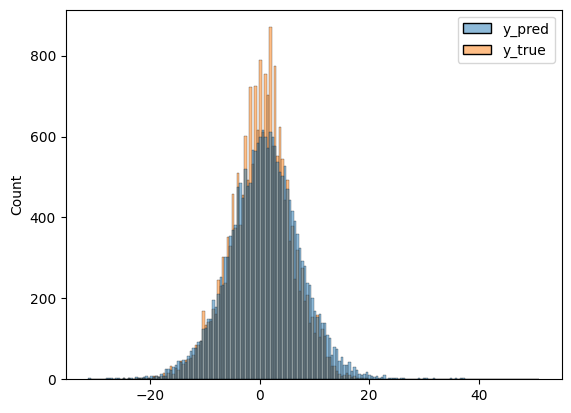

In [230]:
# HUBER ERROR LOSS
sns.histplot(pd.DataFrame({'y_pred': y_pred, 'y_true': y_test_values}))

<Axes: ylabel='Count'>

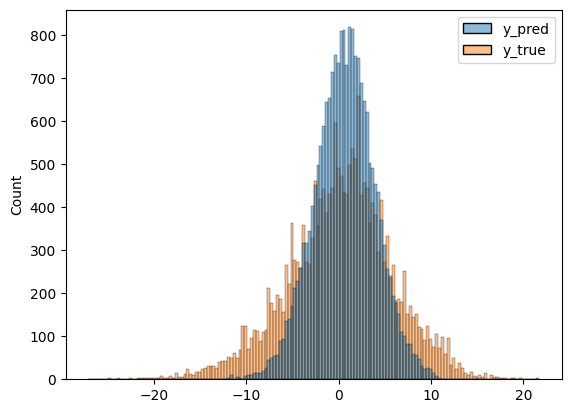

In [205]:
# SQUARED ERROR LOSS
sns.histplot(pd.DataFrame({'y_pred': y_pred, 'y_true': y_test_values}))

“reg:squaredlogerror“, TRY THIS ONE
“reg:logistic“, 
“reg:pseudohubererror“, 
“reg:gamma“, 
and “reg:tweedie“.

## Adding predicted Y's back into the DF to model with betting data

In [279]:
train_test_split_date

'2022-04-27 00:00:00'

In [286]:
df['IS_TEST_ROW'] = 0
df.loc[df['GAME_DATE'] > train_test_split_date , ['GAME_DATE', 'IS_TEST_ROW']] = 1
df.to_pickle()

,PLAYER_ID,TEAM_ID,TEAM_ABBREVIATION,GAME_DATE,PLAYER_NAME,PLUS_MINUS,AST_PCT,AST_RATIO,AST_TOV,DEF_RATING,DREB_PCT,EFG_PCT,MIN,NET_RATING,OFF_RATING,OREB_PCT,PACE,PIE,POSS,PTS,REB_PCT,TM_TOV_PCT,TS_PCT,USG_PCT,IS_TEST_ROW
0,1713,1610612737,ATL,2018-12-03 00:00:00,Vince Carter,-14.9,0.123266,0.169653,0.042814,0.578202,0.250375,0.402074,0.329102,0.501794,0.587002,0.050330,0.014105,0.542849,0.347285,0.421875,0.228959,0.072430,0.431366,0.376921,0
1,1713,1610612737,ATL,2018-12-05 00:00:00,Vince Carter,-14.8,0.132462,0.147789,0.042814,0.546110,0.255056,0.432649,0.366260,0.513995,0.573205,0.064214,0.013059,0.548627,0.383484,0.437500,0.231373,0.072430,0.465736,0.384718,0
2,1713,1610612737,ATL,2018-12-08 00:00:00,Vince Carter,-13.9,0.147144,0.161434,0.057086,0.548544,0.268539,0.466538,0.354895,0.515012,0.577199,0.083652,0.013363,0.554863,0.373303,0.437500,0.249472,0.090059,0.499260,0.418802,0
3,1713,1610612737,ATL,2018-12-12 00:00:00,Vince Carter,-13.9,0.125686,0.163571,0.014271,0.554043,0.256742,0.414582,0.347681,0.500778,0.561224,0.065255,0.014036,0.548169,0.368778,0.445312,0.231071,0.070731,0.447864,0.404767,0
4,1713,1610612737,ATL,2018-12-14 00:00:00,Vince Carter,-11.5,0.125686,0.163571,0.014271,0.595691,0.256742,0.396729,0.346915,0.476435,0.566125,0.047900,0.013775,0.547654,0.367647,0.474609,0.221418,0.070731,0.422377,0.418133,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100079,1631323,1610612762,UTA,1,Simone Fontecchio,0.6,0.092611,0.167352,0.071357,0.566844,0.141199,0.415758,0.251965,0.588337,0.706635,0.133287,0.012827,0.522883,0.263575,0.759766,0.171342,0.267842,0.421003,0.387391,1
100080,1631323,1610612762,UTA,1,Simone Fontecchio,2.3,0.107293,0.190860,0.071357,0.579735,0.141199,0.429121,0.264539,0.622010,0.770627,0.152725,0.012945,0.538387,0.277149,0.761719,0.182202,0.214741,0.455690,0.367788,1
100081,1631323,1610612762,UTA,1,Simone Fontecchio,-0.8,0.128751,0.218313,0.080919,0.630758,0.094382,0.375668,0.305364,0.582356,0.761732,0.152725,0.012803,0.522654,0.319005,0.699219,0.139065,0.267842,0.402813,0.317665,1
100082,1631323,1610612762,UTA,1,Simone Fontecchio,-5.3,0.139561,0.228670,0.095191,0.612729,0.045880,0.277635,0.358884,0.601974,0.773260,0.096147,0.011583,0.523112,0.369910,0.666016,0.080543,0.139550,0.305626,0.312542,1
